In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_test = x_test/255

x_trains = [
    np.array(x_train[y_train != i], dtype = 'float64') for i in range(10)
]
y_trains = [
    np.array(y_train[y_train != i], dtype = 'float64') for i in range(10)
]

def build_model():

    input_layer = tf.keras.layers.Input(x_train.shape[1:])
    x = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)

    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    
    ood_x = tf.keras.layers.Dense(10, activation = 'relu')(x)
    
    regular_output = tf.keras.layers.Dense(10, activation = 'softmax')(x)
    
    ood_x = tf.keras.layers.Concatenate()([ood_x, regular_output])
    ood_output = tf.keras.layers.Dense(28*28, activation = 'sigmoid')(ood_x)
    
    model = tf.keras.models.Model(input_layer, [regular_output, ood_output])
    model.compile(loss = ['sparse_categorical_crossentropy', 'cosine_similarity'], optimizer = 'adam')
    return model

def determine_cutoff(similarities):
    return similarities.mean() + 1*similarities.std()

In [3]:
def run_experiment(ood_value):
    
    print(f'Running Experiment for OOD value {ood_value}')
    callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3)
    model = build_model()
    model.fit(x_trains[ood_value], [y_trains[ood_value], x_trains[ood_value].reshape((x_trains[ood_value].shape[0], -1))], batch_size = 512, epochs = 100, callbacks = [callback], validation_split = 0.2, verbose = 0)
    
    probs, autoencode = model.predict(x_trains[ood_value])
    train_similarities = tf.keras.losses.cosine_similarity(
        np.array(x_trains[ood_value].reshape(x_trains[ood_value].shape[0], -1), dtype = 'float32'),
        np.array(autoencode, dtype = 'float32')
    ).numpy()
    cutoff = determine_cutoff(train_similarities)
    
    probs, autoencode = model.predict(x_test)
    probs = probs.argmax(axis = 1)
    autoencode = autoencode.reshape((autoencode.shape[0], 28, 28))
    similarities = tf.keras.losses.cosine_similarity(np.array(x_test.reshape(x_test.shape[0], -1), dtype = 'float32'), np.array(autoencode.reshape(autoencode.shape[0], -1), dtype = 'float32'))
    
    print(classification_report(y_test, probs))
    
    for i in range(20):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(x_test[i], cmap = 'Greys')
        ax2.imshow(autoencode[i], cmap = 'Greys')
        ax2.set_title(f'Similarity: {similarities[i]}')
        if y_test[i] == ood_value:
            ax1.set_title(f'Out of Domain, Trusted: {similarities[i] <= cutoff}', fontsize = 'small')
        else:
            ax1.set_title(f'In Domain, Trusted: {similarities[i] <= cutoff}', fontsize = 'small')
        plt.show()
    
    plt.hist(similarities[y_test != ood_value].numpy())
    plt.title('Similarity Distribution for ID test data', fontsize = 'x-large')
    plt.show()
        
    plt.hist(similarities[y_test == ood_value].numpy())
    plt.title('Similarity Distribution for OOD test data', fontsize = 'x-large')
    plt.show()
    
    print('OOD Detections: (True Indicates Trusted)')
    print(pd.Series(similarities[y_test == ood_value] <= cutoff).value_counts())
    print('\n')
    
    print('ID Detections: (True Indicates Trusted)')
    print(pd.Series(similarities[y_test != ood_value] <= cutoff).value_counts())

Running Experiment for OOD value 0
Metal device set to: Apple M1


2021-12-09 11:12:15.438776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-09 11:12:15.438858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-09 11:12:15.624154: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-09 11:12:15.826346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:16.672892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:23.933964: I tensorflow/core/grappler/o

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.98      0.99      0.99      1135
           2       0.74      0.97      0.84      1032
           3       0.95      0.98      0.96      1010
           4       0.99      0.96      0.97       982
           5       0.83      0.93      0.88       892
           6       0.72      0.98      0.83       958
           7       0.92      0.98      0.95      1028
           8       0.88      0.98      0.93       974
           9       0.93      0.96      0.94      1009

    accuracy                           0.87     10000
   macro avg       0.79      0.87      0.83     10000
weighted avg       0.80      0.87      0.83     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


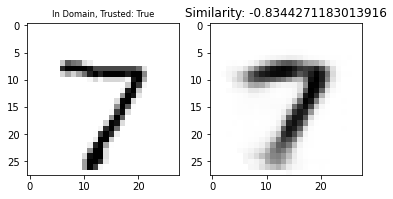

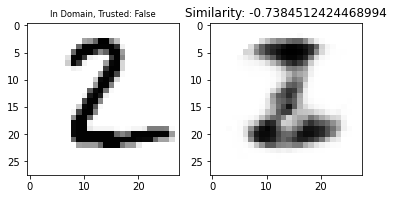

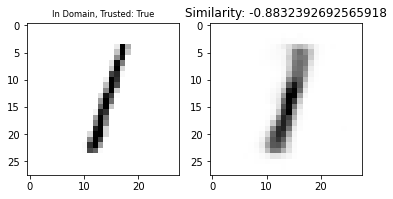

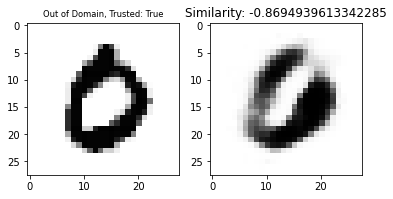

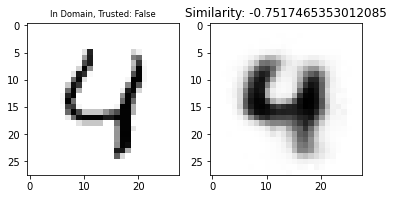

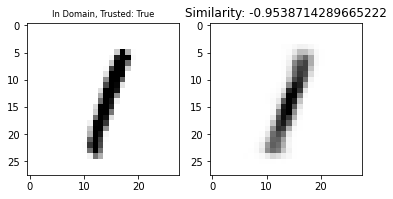

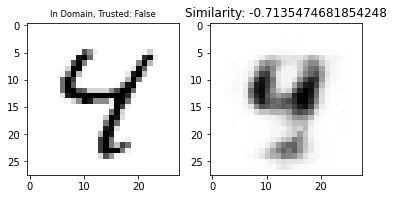

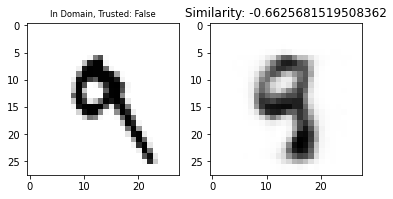

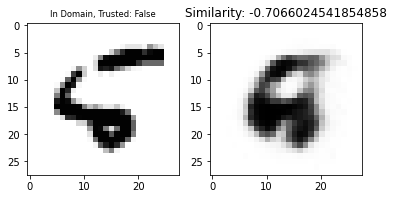

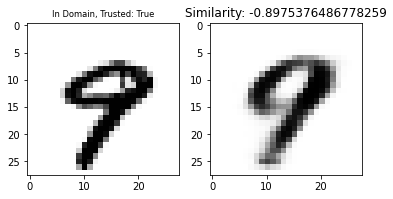

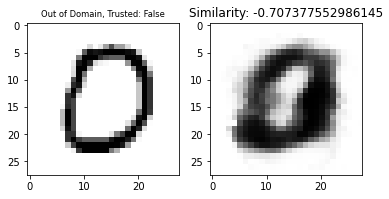

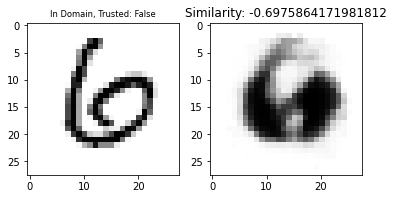

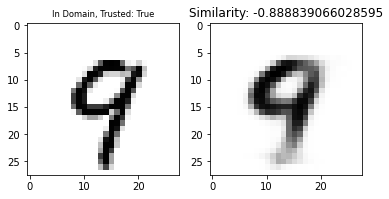

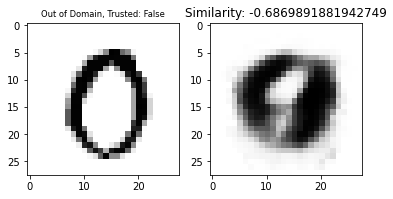

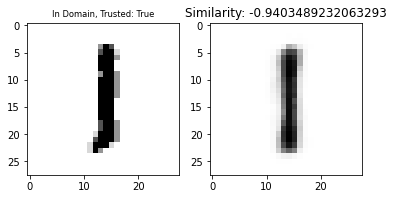

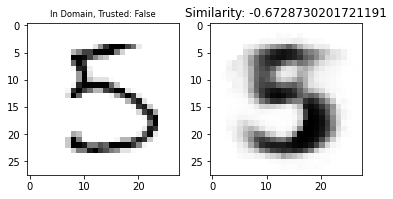

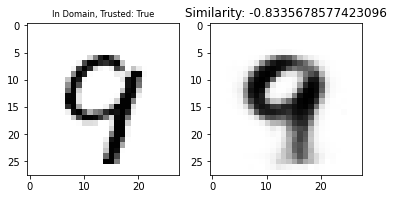

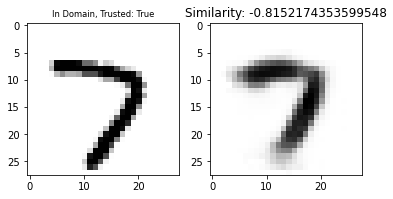

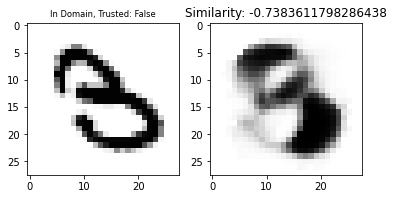

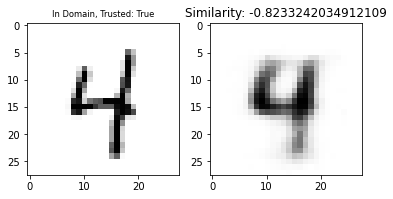

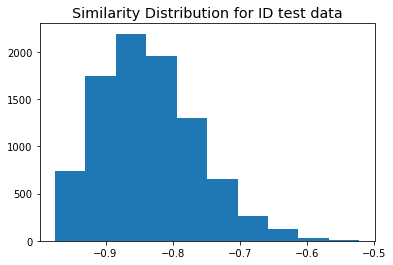

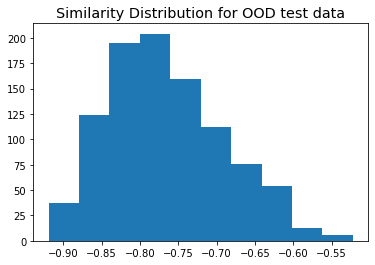

OOD Detections: (True Indicates Trusted)
True     582
False    398
dtype: int64


ID Detections: (True Indicates Trusted)
True     7785
False    1235
dtype: int64


In [4]:
run_experiment(0)

Running Experiment for OOD value 1


2021-12-09 11:12:28.534631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:29.379357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:35.361794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.00      0.00      0.00      1135
           2       0.87      0.99      0.92      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.97      0.97       958
           7       0.64      0.97      0.77      1028
           8       0.66      0.97      0.78       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.86     10000
   macro avg       0.80      0.87      0.83     10000
weighted avg       0.78      0.86      0.81     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


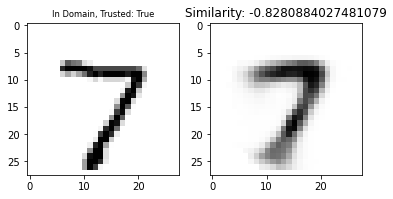

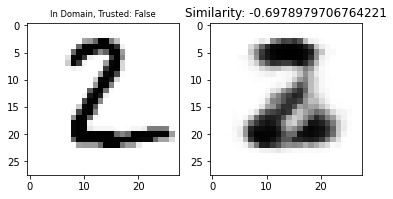

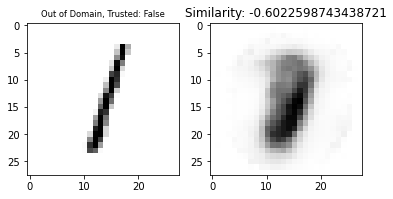

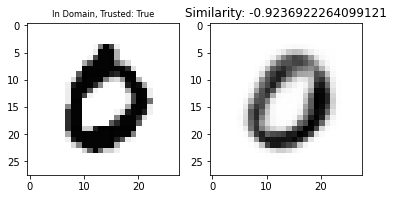

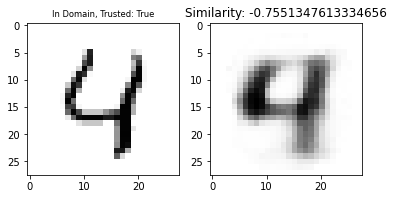

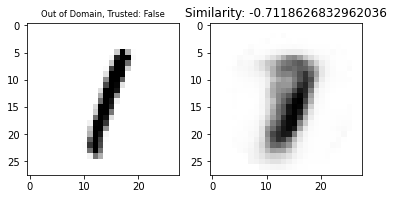

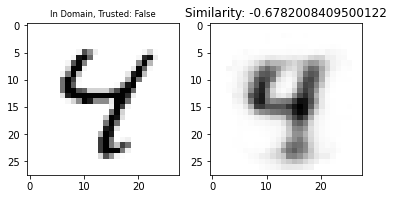

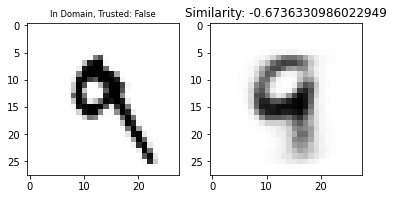

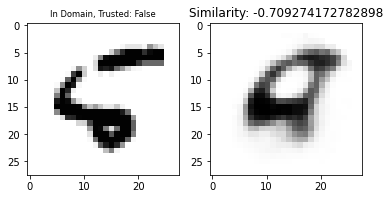

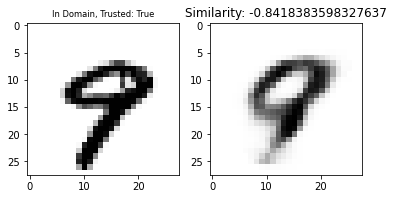

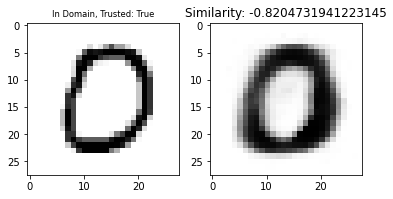

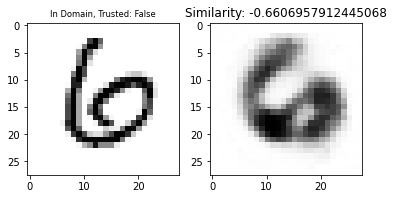

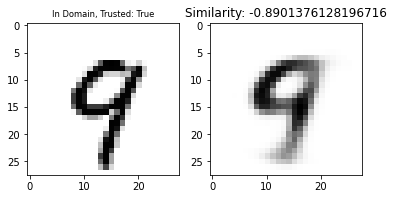

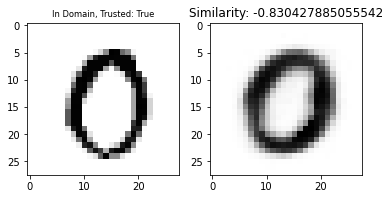

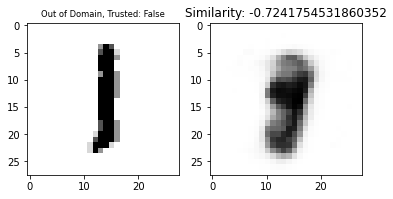

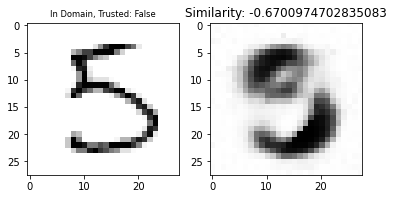

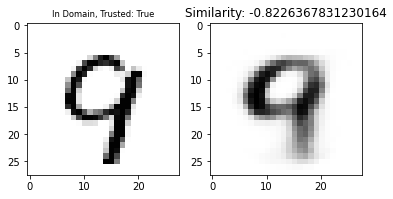

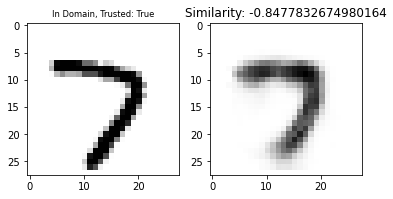

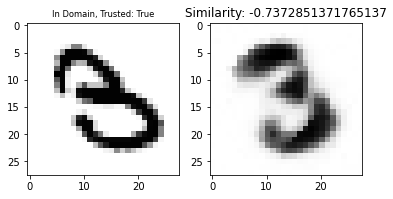

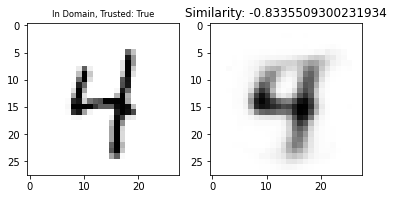

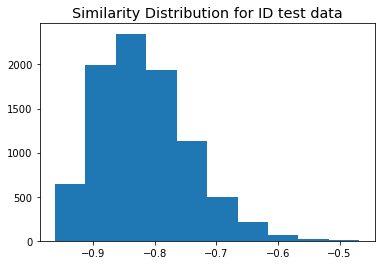

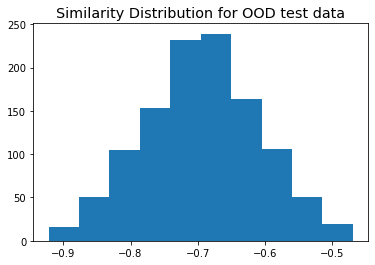

OOD Detections: (True Indicates Trusted)
False    786
True     349
dtype: int64


ID Detections: (True Indicates Trusted)
True     7691
False    1174
dtype: int64


In [5]:
run_experiment(1)

Running Experiment for OOD value 2


2021-12-09 11:12:40.146572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:40.965618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:47.833833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.94      0.99      0.96      1135
           2       0.00      0.00      0.00      1032
           3       0.74      0.98      0.84      1010
           4       0.95      0.97      0.96       982
           5       0.99      0.95      0.97       892
           6       0.87      0.98      0.92       958
           7       0.90      0.97      0.94      1028
           8       0.68      0.98      0.80       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.87     10000
   macro avg       0.80      0.88      0.83     10000
weighted avg       0.79      0.87      0.83     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


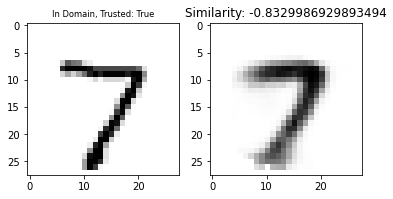

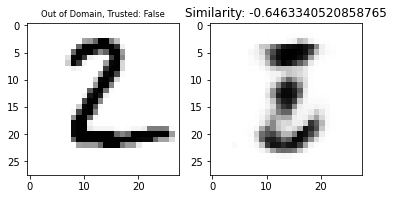

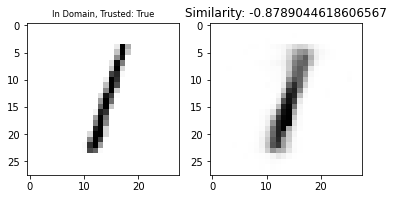

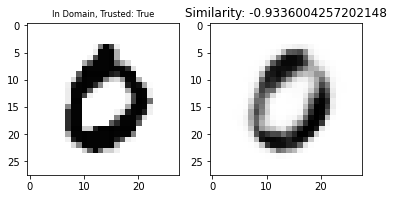

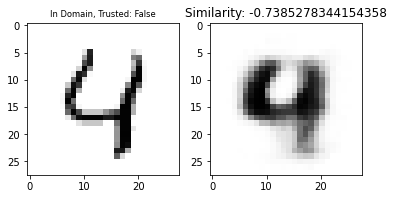

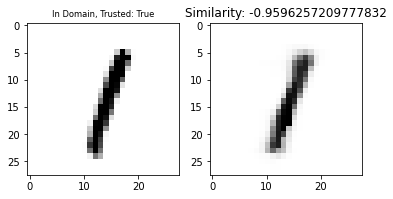

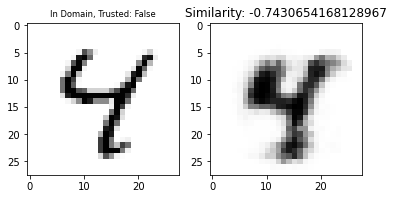

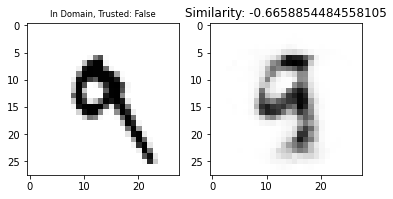

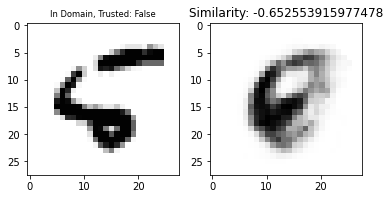

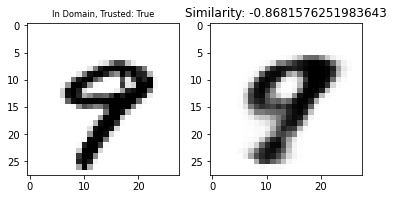

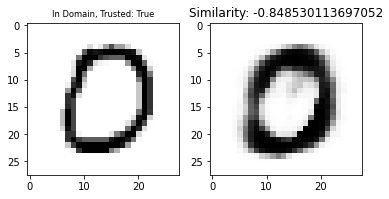

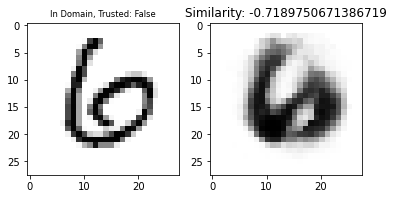

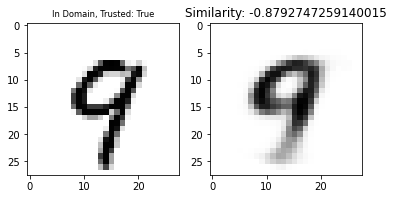

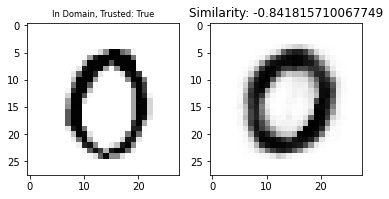

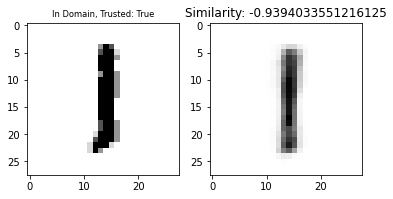

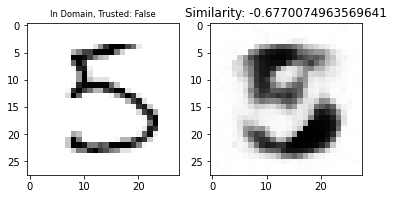

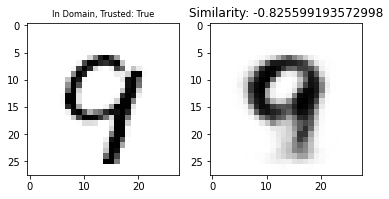

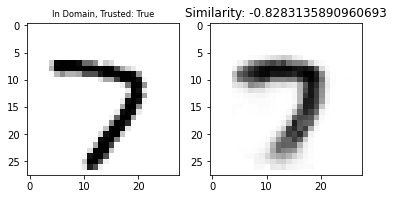

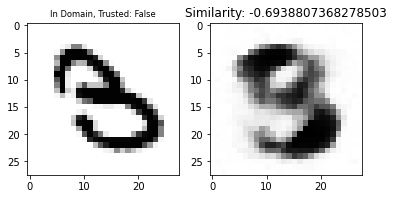

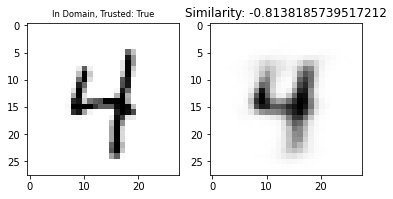

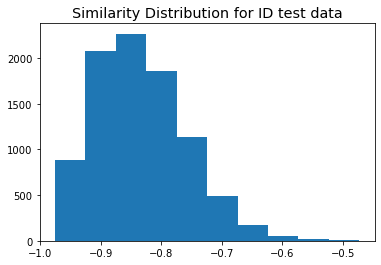

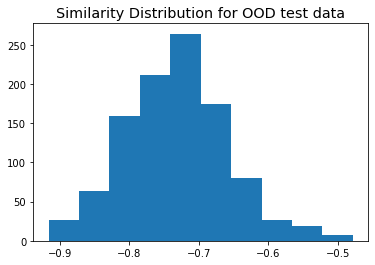

OOD Detections: (True Indicates Trusted)
False    621
True     411
dtype: int64


ID Detections: (True Indicates Trusted)
True     7697
False    1271
dtype: int64


In [6]:
run_experiment(2)

Running Experiment for OOD value 3


2021-12-09 11:12:52.564450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:53.387659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:12:58.651413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.82      0.98      0.89      1032
           3       0.00      0.00      0.00      1010
           4       0.97      0.97      0.97       982
           5       0.68      0.96      0.80       892
           6       0.98      0.97      0.97       958
           7       0.96      0.97      0.96      1028
           8       0.74      0.96      0.84       974
           9       0.86      0.97      0.91      1009

    accuracy                           0.88     10000
   macro avg       0.80      0.88      0.83     10000
weighted avg       0.80      0.88      0.83     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


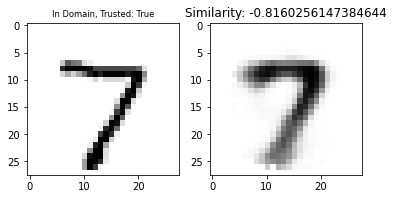

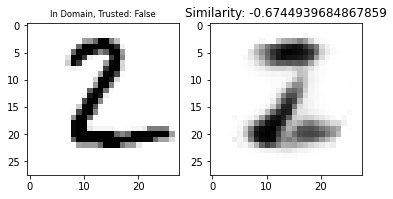

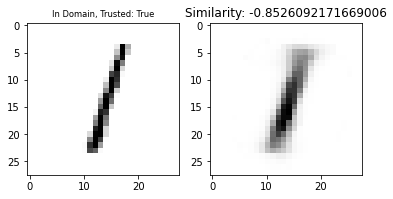

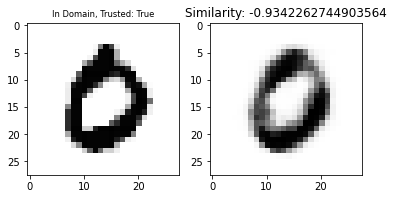

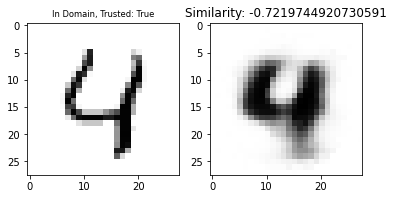

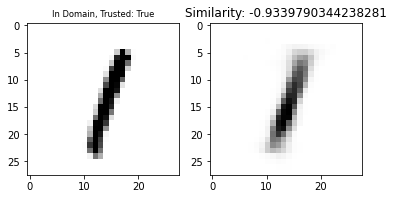

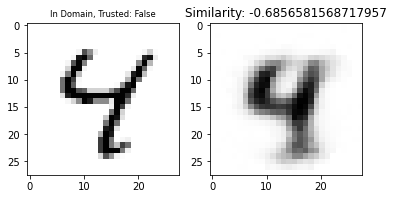

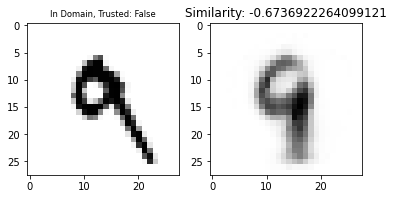

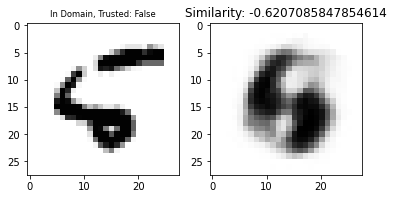

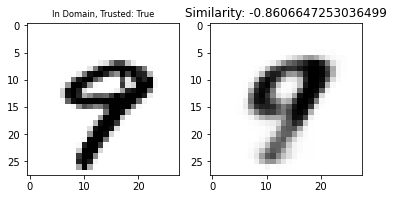

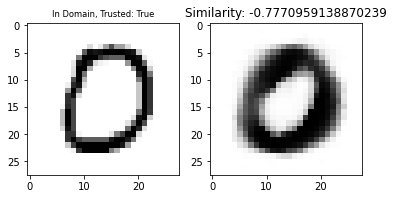

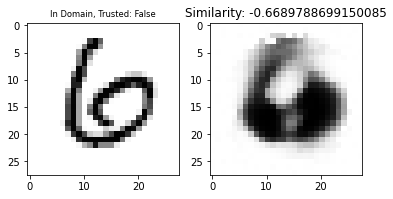

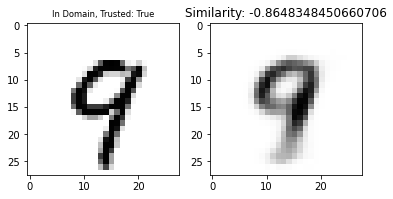

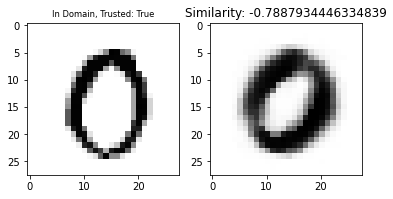

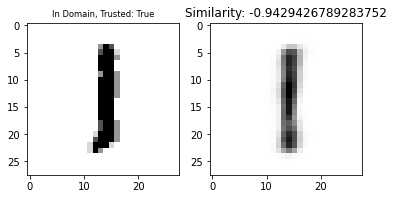

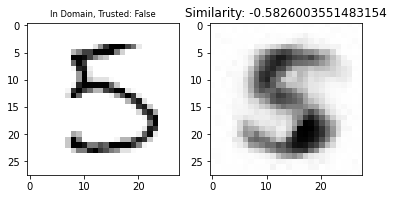

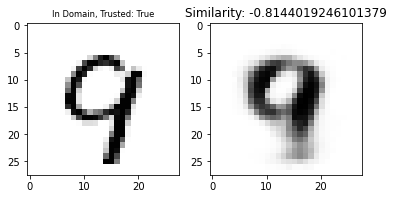

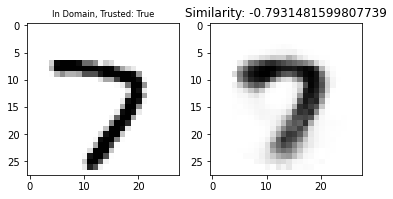

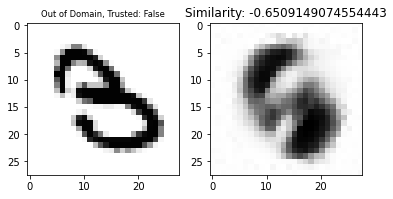

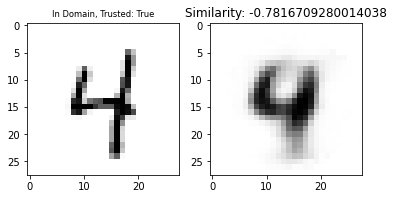

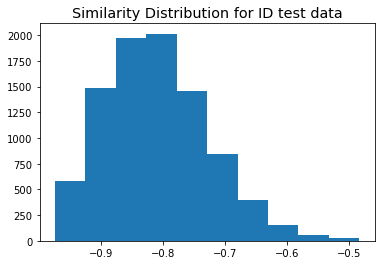

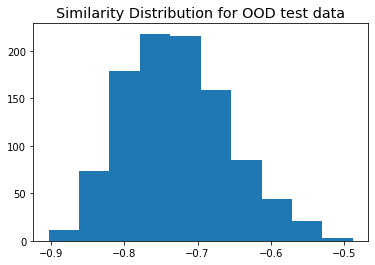

OOD Detections: (True Indicates Trusted)
True     587
False    423
dtype: int64


ID Detections: (True Indicates Trusted)
True     7740
False    1250
dtype: int64


In [7]:
run_experiment(3)

Running Experiment for OOD value 4


2021-12-09 11:13:03.257921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:04.074946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:09.451083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.97      0.98      1135
           2       0.93      0.98      0.96      1032
           3       0.96      0.98      0.97      1010
           4       0.00      0.00      0.00       982
           5       0.97      0.96      0.97       892
           6       0.90      0.99      0.94       958
           7       0.92      0.98      0.95      1028
           8       0.90      0.97      0.93       974
           9       0.56      0.95      0.71      1009

    accuracy                           0.88     10000
   macro avg       0.81      0.88      0.84     10000
weighted avg       0.81      0.88      0.84     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


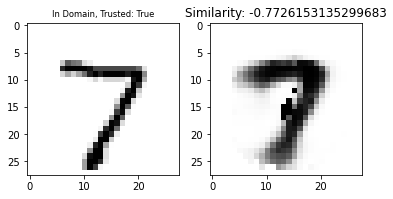

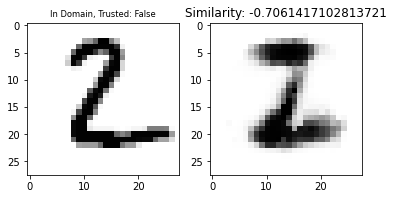

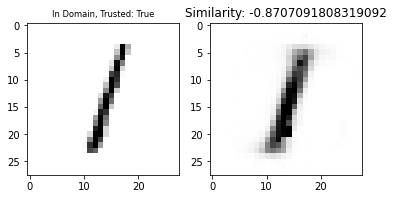

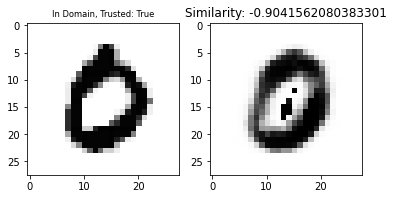

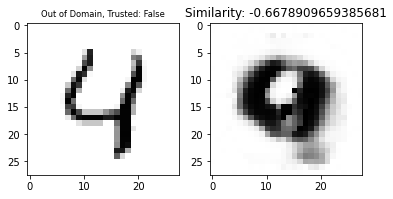

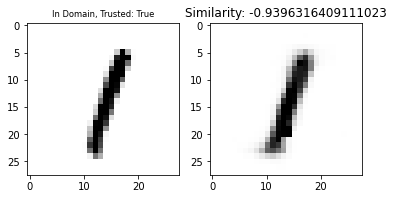

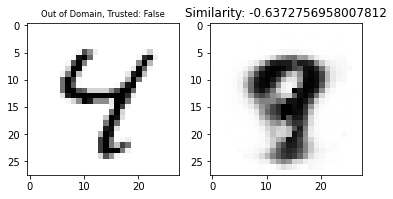

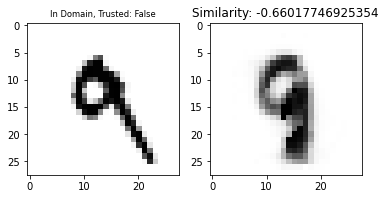

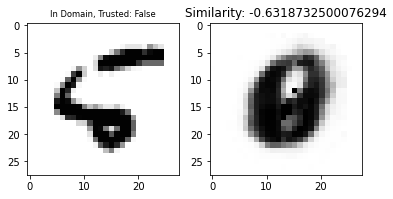

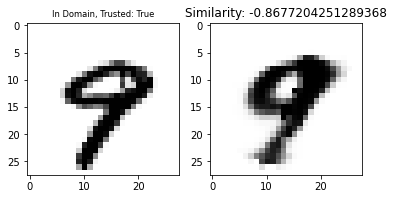

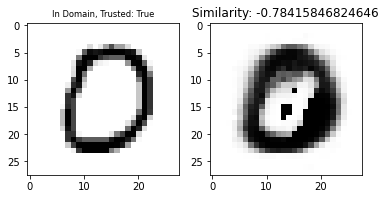

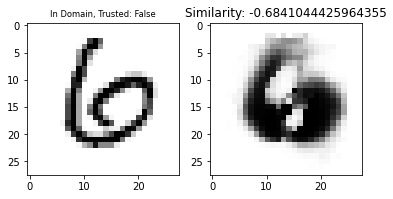

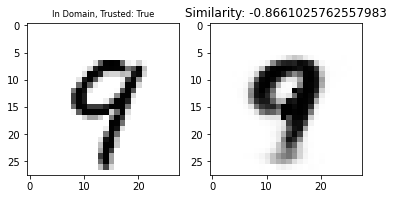

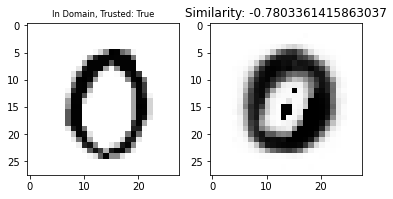

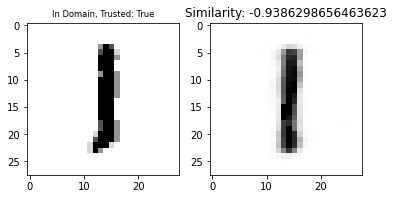

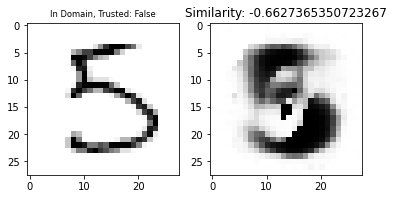

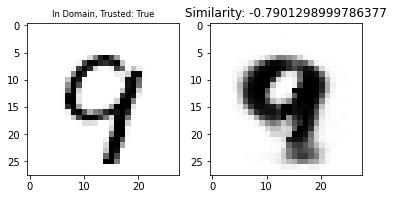

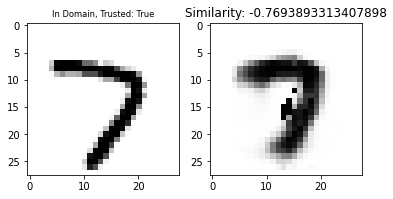

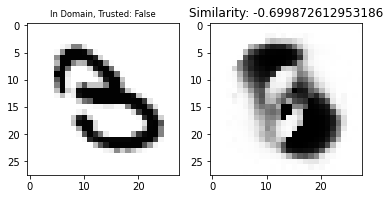

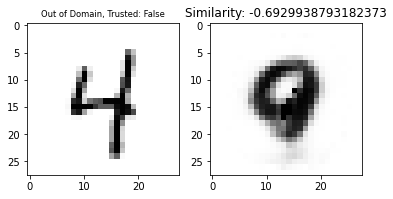

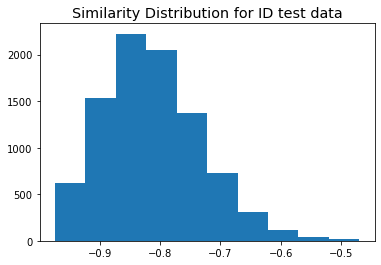

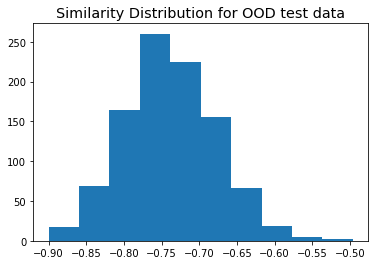

OOD Detections: (True Indicates Trusted)
True     583
False    399
dtype: int64


ID Detections: (True Indicates Trusted)
True     7738
False    1280
dtype: int64


In [8]:
run_experiment(4)

Running Experiment for OOD value 5


2021-12-09 11:13:14.393489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:15.315425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:22.241271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.66      0.99      0.79      1010
           4       0.98      0.97      0.97       982
           5       0.00      0.00      0.00       892
           6       0.91      0.98      0.95       958
           7       0.97      0.97      0.97      1028
           8       0.76      0.94      0.84       974
           9       0.93      0.95      0.94      1009

    accuracy                           0.89     10000
   macro avg       0.81      0.87      0.84     10000
weighted avg       0.82      0.89      0.85     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


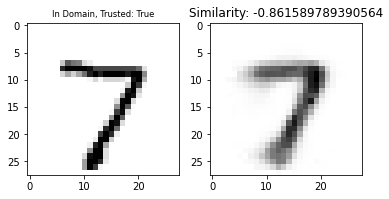

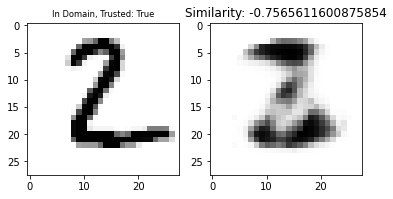

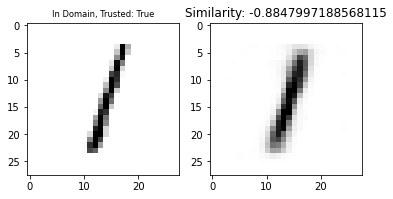

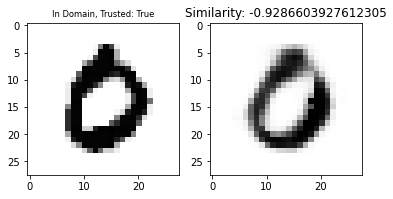

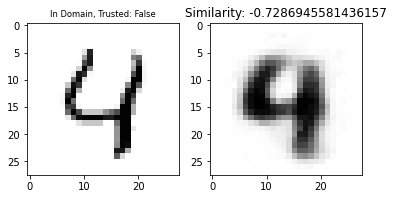

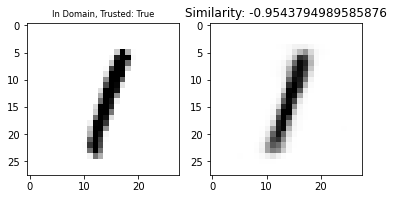

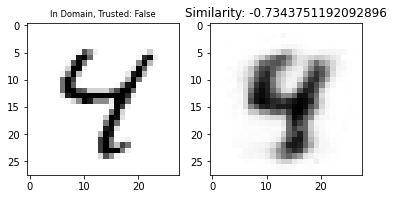

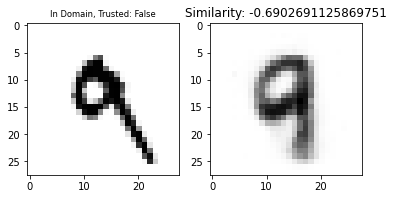

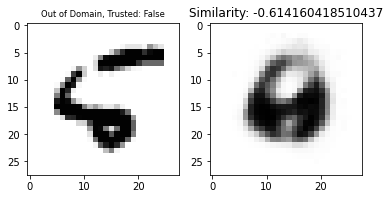

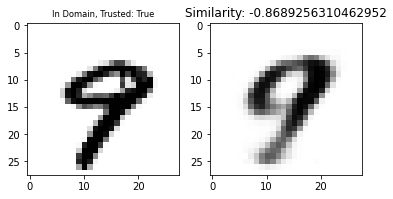

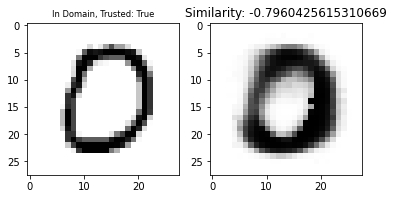

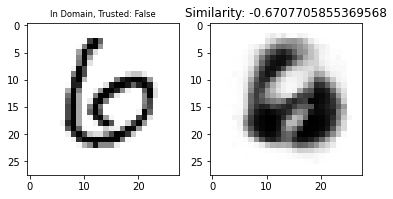

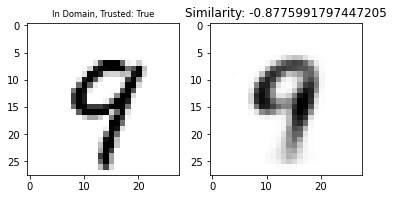

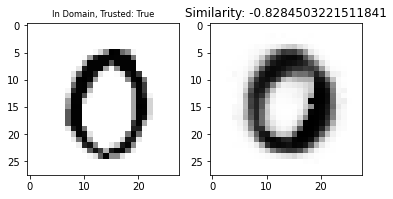

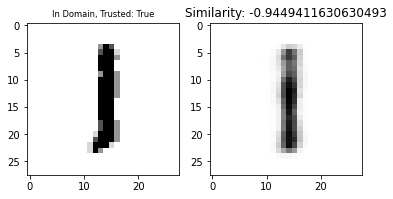

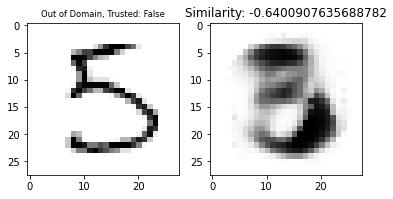

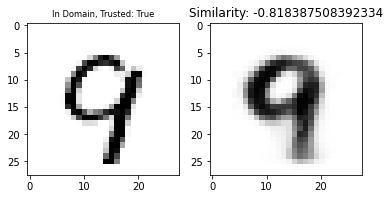

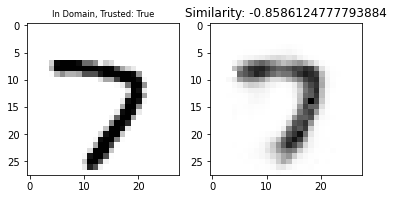

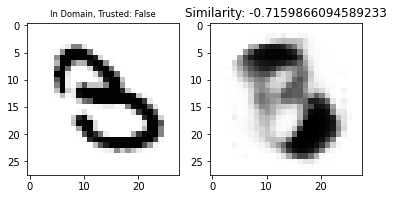

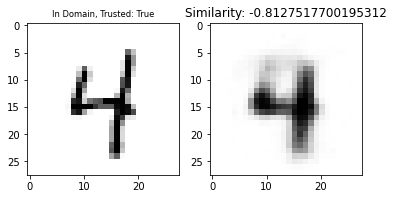

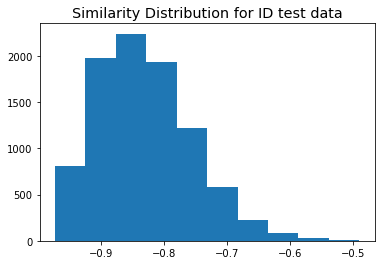

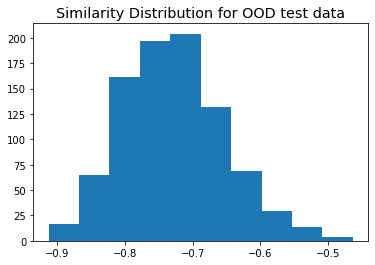

OOD Detections: (True Indicates Trusted)
False    527
True     365
dtype: int64


ID Detections: (True Indicates Trusted)
True     7841
False    1267
dtype: int64


In [9]:
run_experiment(5)

Running Experiment for OOD value 6


2021-12-09 11:13:27.047994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:27.895738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:34.614602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.93      0.97      0.95      1032
           3       0.96      0.97      0.97      1010
           4       0.65      0.97      0.78       982
           5       0.73      0.98      0.84       892
           6       0.00      0.00      0.00       958
           7       0.97      0.97      0.97      1028
           8       0.93      0.96      0.94       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.88     10000
   macro avg       0.81      0.88      0.84     10000
weighted avg       0.81      0.88      0.84     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


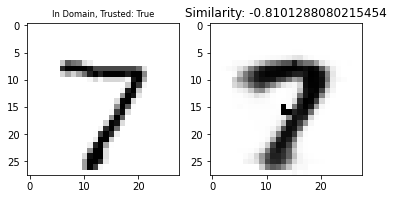

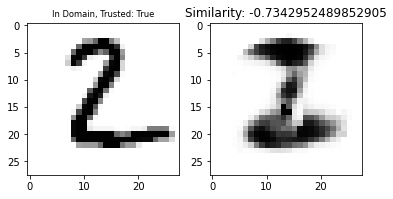

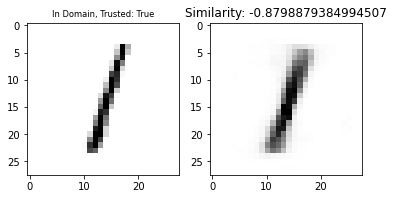

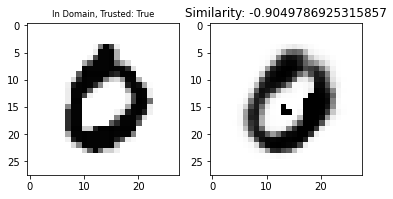

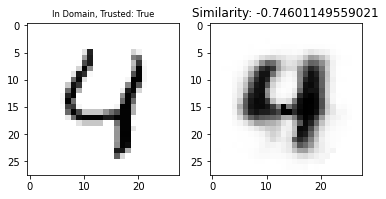

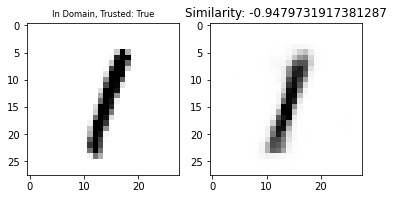

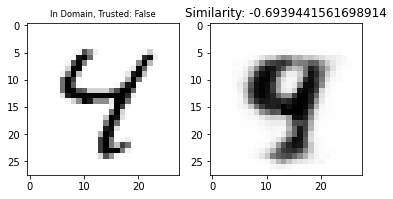

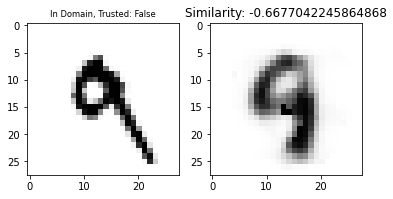

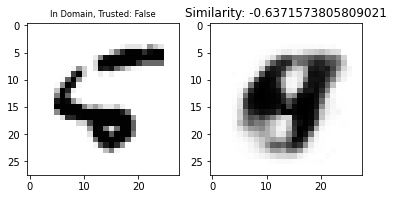

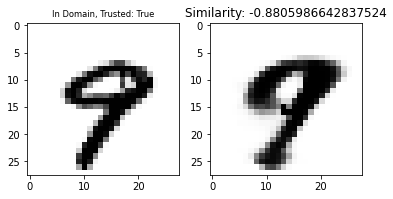

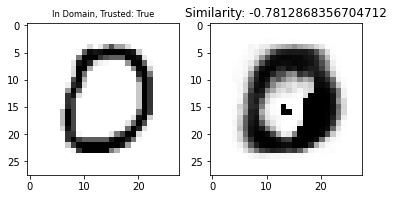

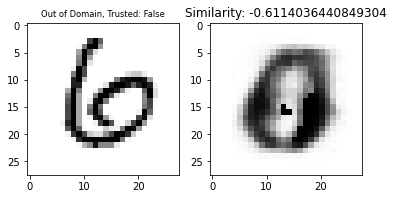

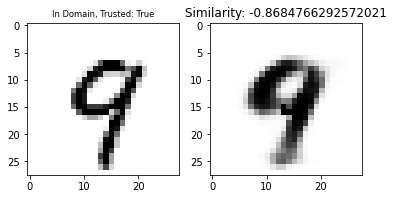

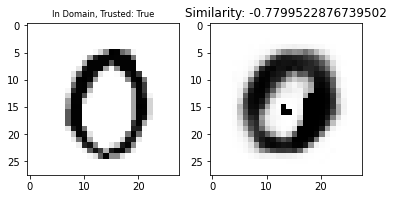

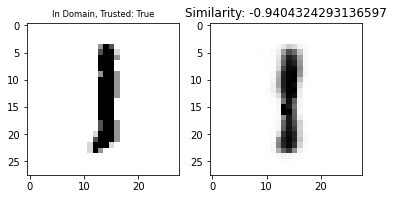

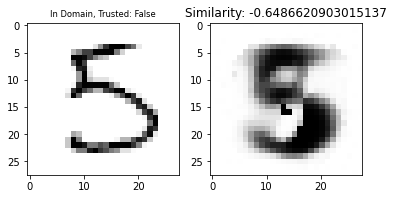

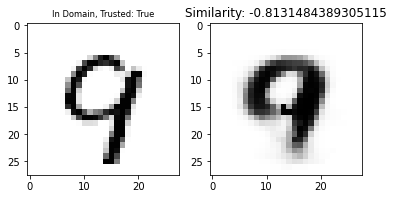

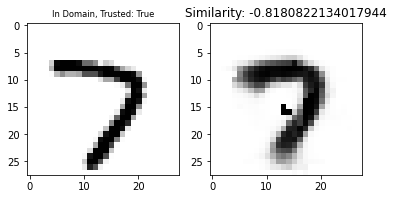

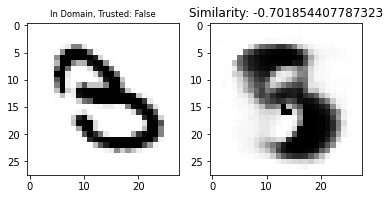

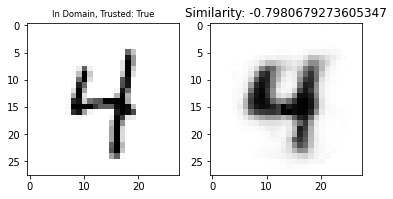

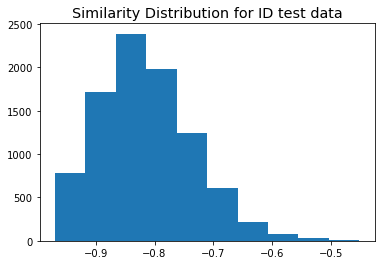

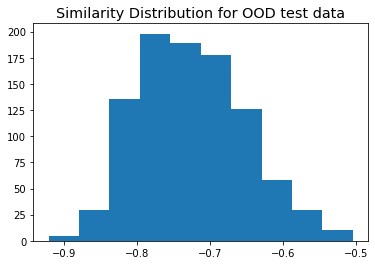

OOD Detections: (True Indicates Trusted)
True     481
False    477
dtype: int64


ID Detections: (True Indicates Trusted)
True     7806
False    1236
dtype: int64


In [10]:
run_experiment(6)

Running Experiment for OOD value 7


2021-12-09 11:13:39.418080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:40.294833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:46.638751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.90      0.97      0.94      1032
           3       0.79      0.98      0.88      1010
           4       0.94      0.97      0.96       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.00      0.00      0.00      1028
           8       0.94      0.97      0.95       974
           9       0.60      0.96      0.74      1009

    accuracy                           0.87     10000
   macro avg       0.81      0.88      0.84     10000
weighted avg       0.80      0.87      0.83     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


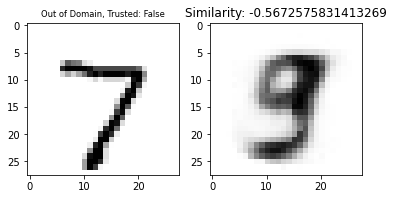

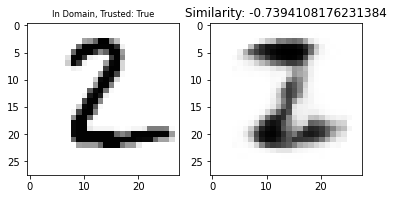

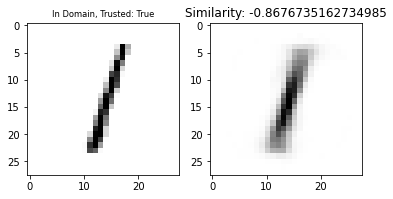

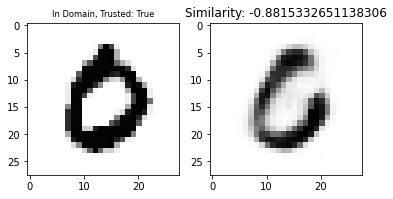

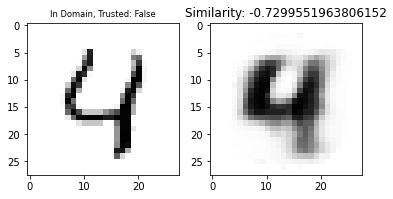

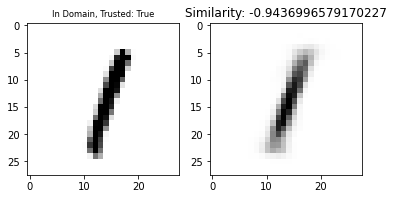

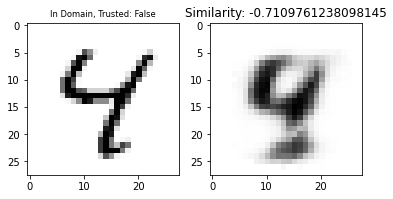

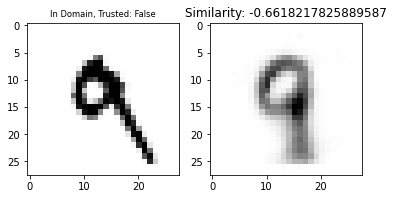

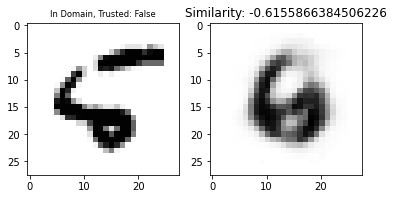

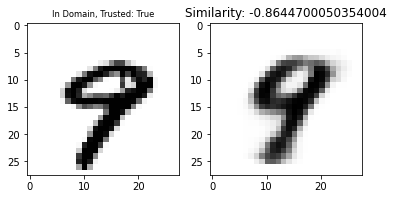

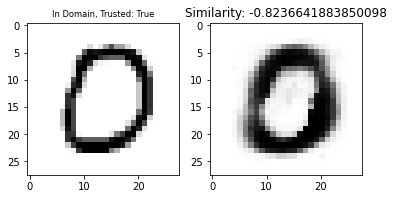

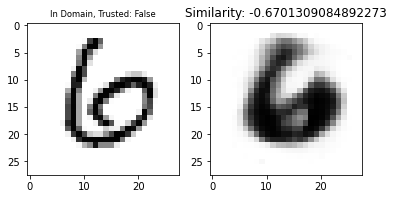

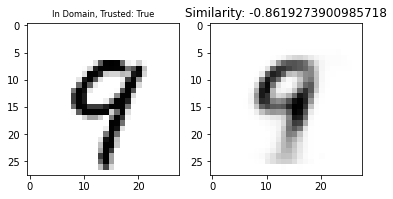

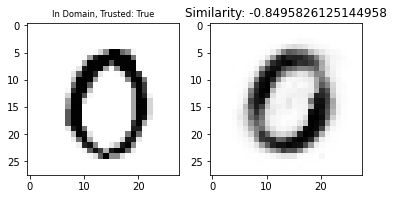

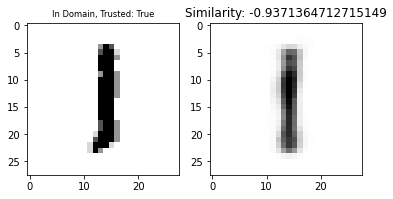

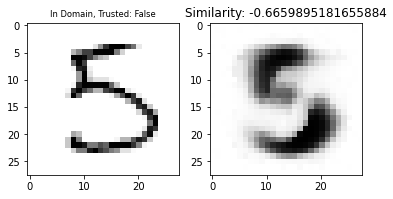

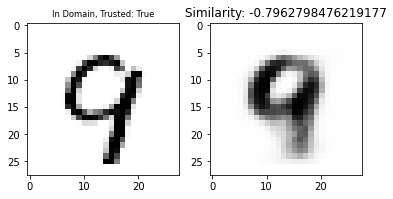

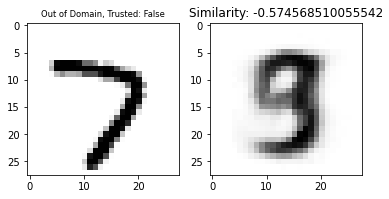

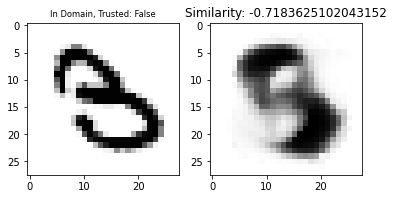

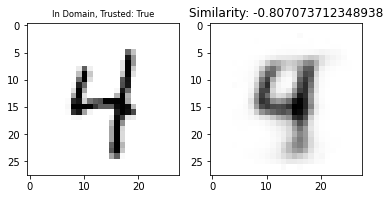

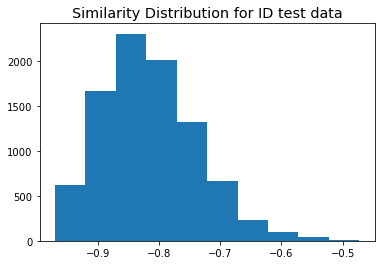

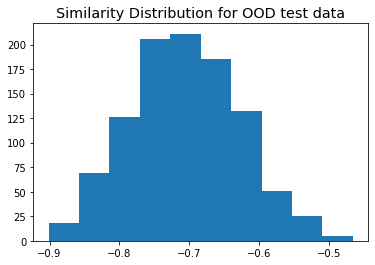

OOD Detections: (True Indicates Trusted)
False    625
True     403
dtype: int64


ID Detections: (True Indicates Trusted)
True     7723
False    1249
dtype: int64


In [11]:
run_experiment(7)

Running Experiment for OOD value 8


2021-12-09 11:13:51.246053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:52.125066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:13:59.465764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.83      0.98      0.90      1032
           3       0.68      0.97      0.80      1010
           4       0.97      0.95      0.96       982
           5       0.86      0.97      0.91       892
           6       0.93      0.99      0.96       958
           7       0.98      0.95      0.96      1028
           8       0.00      0.00      0.00       974
           9       0.81      0.97      0.88      1009

    accuracy                           0.88     10000
   macro avg       0.80      0.88      0.83     10000
weighted avg       0.80      0.88      0.84     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


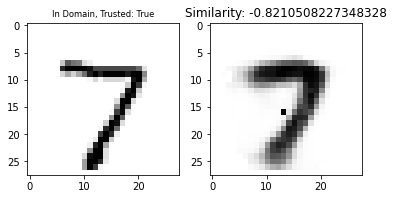

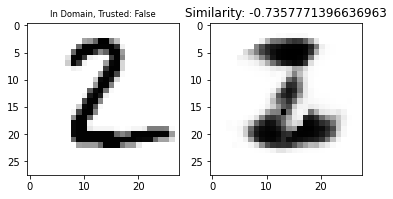

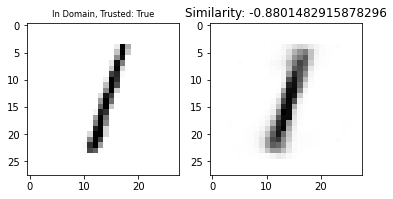

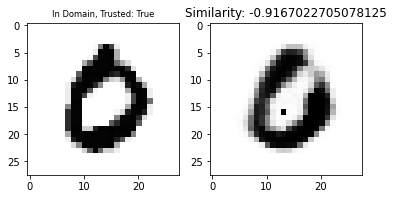

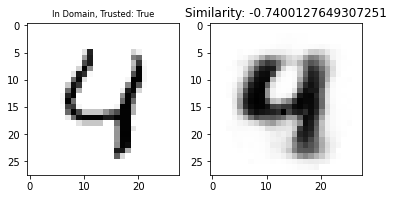

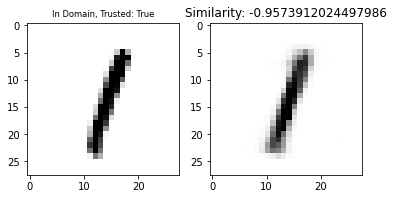

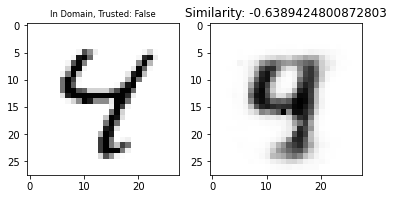

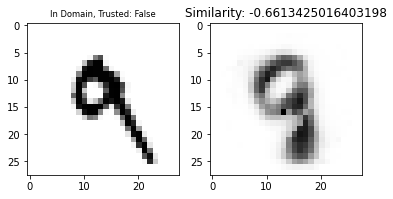

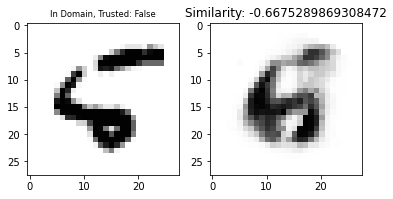

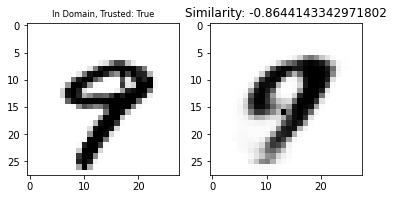

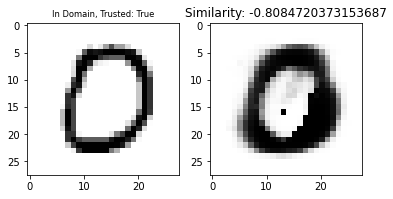

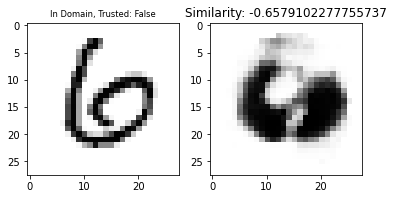

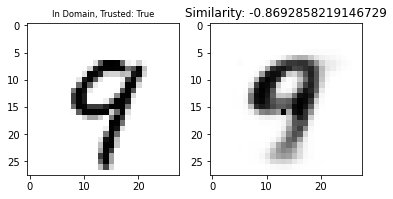

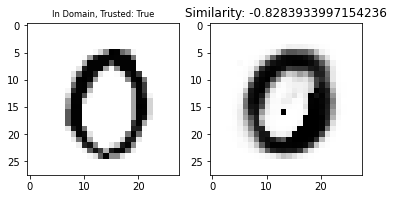

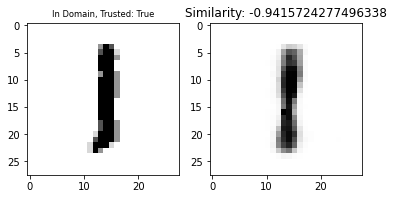

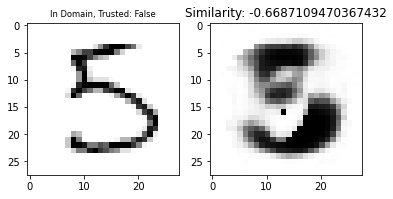

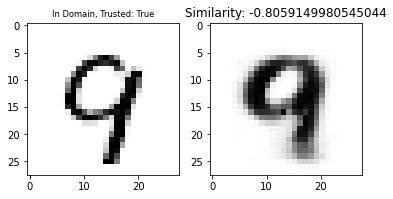

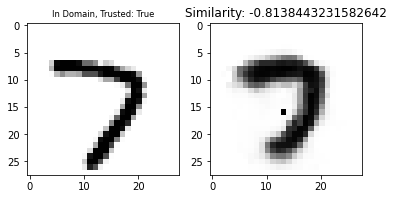

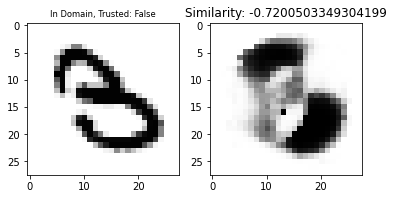

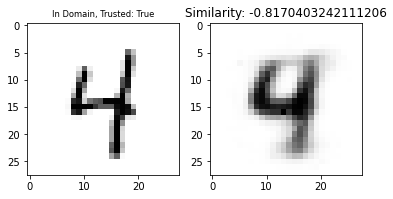

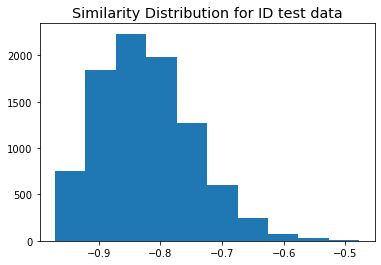

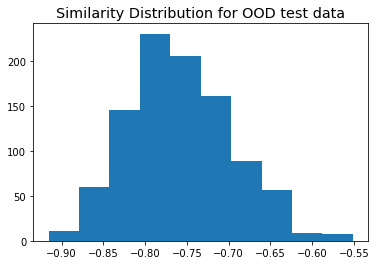

OOD Detections: (True Indicates Trusted)
True     617
False    357
dtype: int64


ID Detections: (True Indicates Trusted)
True     7756
False    1270
dtype: int64


In [12]:
run_experiment(8)

Running Experiment for OOD value 9


2021-12-09 11:14:04.385931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:14:05.306091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:14:12.714361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.93      0.98      0.95      1010
           4       0.61      0.99      0.76       982
           5       0.95      0.96      0.96       892
           6       0.97      0.98      0.97       958
           7       0.80      0.97      0.88      1028
           8       0.90      0.97      0.93       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.88     10000
   macro avg       0.81      0.88      0.84     10000
weighted avg       0.81      0.88      0.84     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


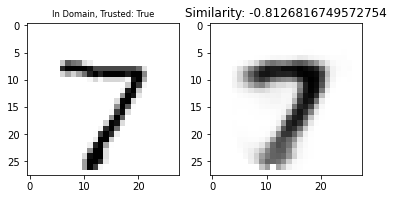

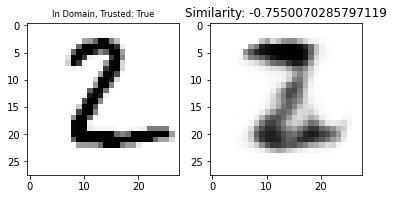

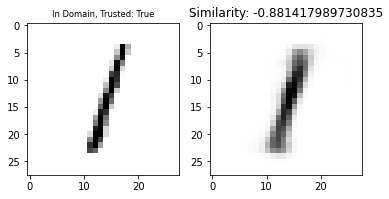

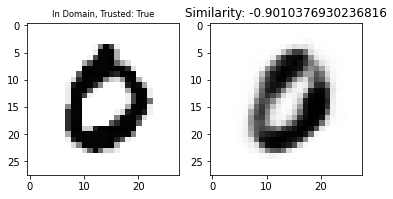

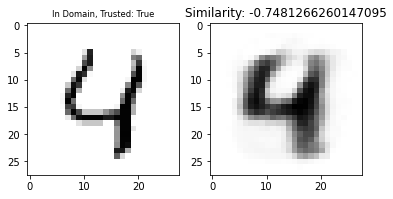

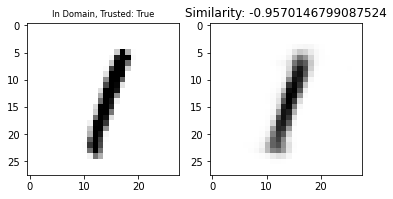

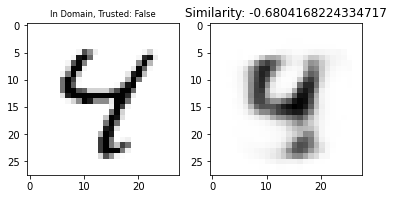

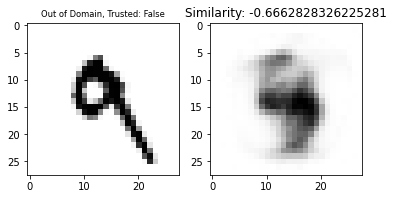

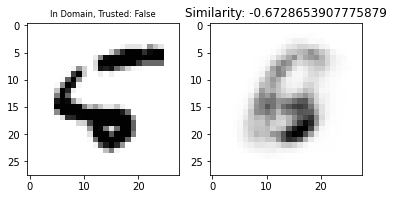

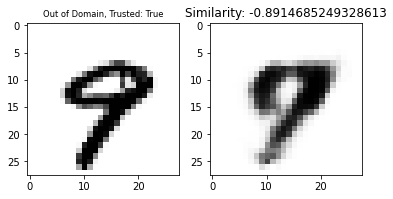

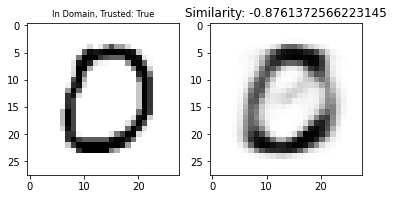

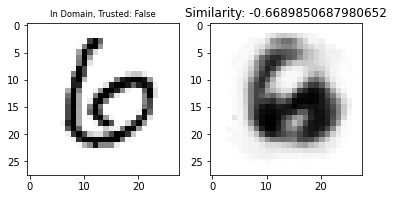

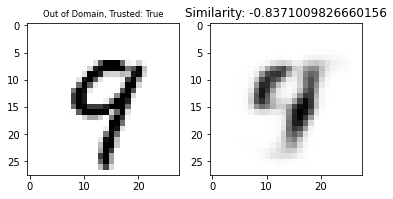

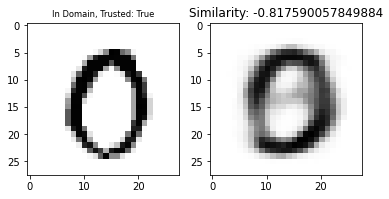

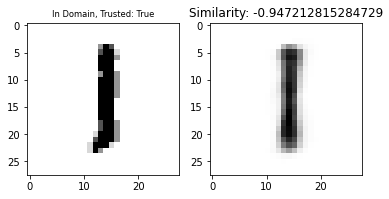

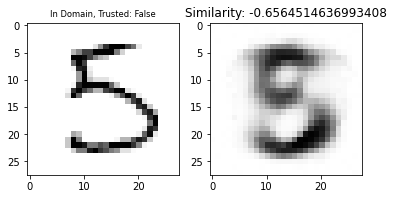

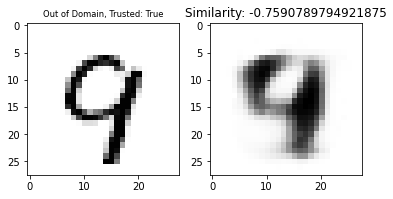

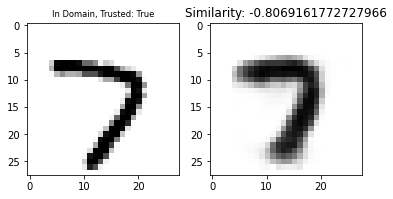

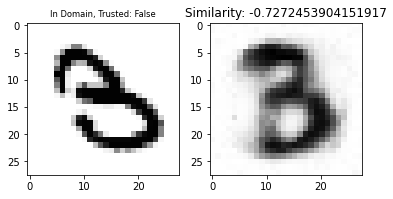

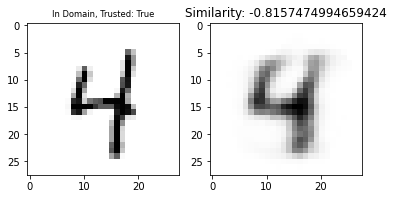

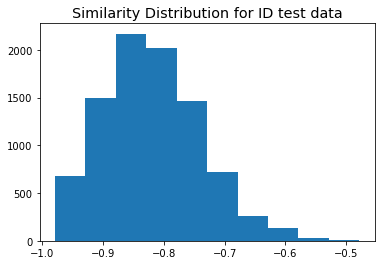

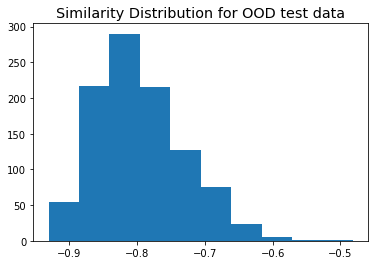

OOD Detections: (True Indicates Trusted)
True     837
False    172
dtype: int64


ID Detections: (True Indicates Trusted)
True     7760
False    1231
dtype: int64


In [13]:
run_experiment(9)